
# How much is an avocado?

<img src="fig/avocado2.jpg" width=1000  />

__Goal__: estimate price elasticity of avocados and optimize the price (price elasticity = impact of the change in price on the sales volume).

The analysis is based on the following steps:
1. Fit a Bayesian regression model.
1. Inspect the model to verify its correctness.
1. Predict sales volume for different prices.
1. Propose the profit-maximizing price and the associated uncertainty.

The data source: https://www.kaggle.com/datasets/timmate/avocado-prices-2020?resource=download

In [11]:
# Import packages
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import pymc3 as pm
import arviz as az

In [12]:
# load data
# load full data set and preview the table
avocado_raw = pd.read_csv("data/avocado-updated-2020.csv", parse_dates=['date'])
avocado_raw.head()

,date,average_price,total_volume,4046,4225,4770,total_bags,small_bags,large_bags,xlarge_bags,type,year,geography
0,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.0,conventional,2015,Albany
1,2015-01-04,1.79,1373.95,57.42,153.88,0.00,1162.65,1162.65,0.00,0.0,organic,2015,Albany
2,2015-01-04,1.00,435021.49,364302.39,23821.16,82.15,46815.79,16707.15,30108.64,0.0,conventional,2015,Atlanta
3,2015-01-04,1.76,3846.69,1500.15,938.35,0.00,1408.19,1071.35,336.84,0.0,organic,2015,Atlanta
4,2015-01-04,1.08,788025.06,53987.31,552906.04,39995.03,141136.68,137146.07,3990.61,0.0,conventional,2015,Baltimore/Washington


In [13]:
# preprocces the data
# randomly takes only one daily record
# avocado = avocado_raw.groupby('date', group_keys=False).apply(lambda df: df.sample(1, random_state=42))
np.random.seed(42)
avocado = avocado_raw.groupby('date', as_index=False).agg(np.random.choice)
avocado.head()

,date,average_price,total_volume,4046,4225,4770,total_bags,small_bags,large_bags,xlarge_bags,type,year,geography
0,2015-01-04,0.95,309024.22,2843648.26,1127882.44,6.98,13598.46,137146.07,15033.42,13928.01,organic,2015,South Central
1,2015-01-11,1.52,1614.56,0.00,558487.79,14197.05,111524.61,151330.87,285.28,0.00,organic,2015,Boise
2,2015-01-18,1.19,1091677.29,28457.99,63826.82,0.00,300.00,773.33,2.22,0.00,conventional,2015,Hartford/Springfield
3,2015-01-25,1.18,2928692.32,28037.64,271152.06,0.00,25973.12,8875.65,0.00,0.00,organic,2015,New Orleans/Mobile
4,2015-02-01,0.71,35085.70,33.12,65784.29,32.15,383.33,142049.31,125798.21,0.00,organic,2015,South Central


In [14]:
# drop redundant columns
avocado = avocado[['date', 'average_price', 'total_volume', 'type']]
# rename columns
avocado.rename(columns={"average_price": "price", "total_volume": "volume"}, inplace=True)
# one hot encoding 
type_dummies = pd.get_dummies(avocado.type)
avocado = pd.concat([avocado, type_dummies], axis=1)

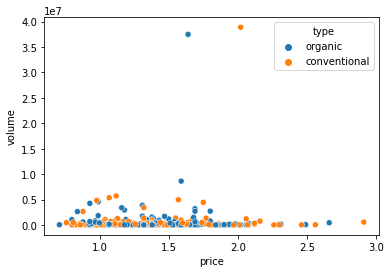

In [17]:
# visualize the data
sns.scatterplot(data=avocado, x="price", y="volume", hue="type")
plt.show()

In [18]:
# few additional cleaning and preprocessing step and show final result
avocado.rename(columns={"organic": "type_organic"}, inplace=True)
avocado = avocado[['date', 'price', 'volume', 'type_organic']]

# Based on the scatter plot above it seems that we have two outliers.
# To avoid scaling errors in PYMC3, we must remove these outliers or do the scaling of the variables.
# Since we don't really know if they are real outliers, we will do log scaling 
avocado['volume'] = np.log(avocado['volume'])

display(avocado)

,date,price,volume,type_organic
0,2015-01-04,0.95,12.641175,1
1,2015-01-11,1.52,7.386818,1
2,2015-01-18,1.19,13.903226,0
3,2015-01-25,1.18,14.890067,1
4,2015-02-01,0.71,10.465549,1
...,...,...,...,...
301,2020-11-01,1.38,9.178198,1
302,2020-11-08,1.20,10.854772,1
303,2020-11-15,1.00,12.889875,1
304,2020-11-22,1.18,9.623861,1


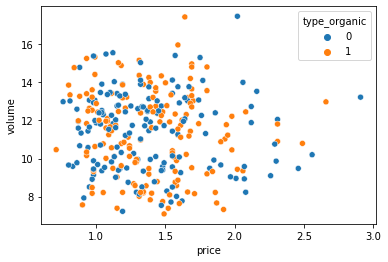

In [20]:
# visualize the data
sns.scatterplot(data=avocado, x="price", y="volume", hue="type_organic")
plt.show()

#### Fitting the model

We can use a linear regression model to estimate the avocado price elasticity. The regression formula should be:

$$volume \sim \mathcal{N}(\beta_0 + \beta_1 price + \beta_2 typeOrganic,\,\sigma)$$

Here, $\beta_1$ will be the price elasticity, that is the impact of price on sales. We will assume that the elasticity is the same for regular and organic avocados. We also expect it to be negative: the higher the price, the lower the sales, that's the case for most goods. To incorporate this prior knowledge into the model, we decide to use a normal distribution with mean `-80` as the prior for price. How would we build such a model?

In [6]:
%%time
formula = "volume ~ price + type_organic"

with pm.Model() as model:
    
    priors = {"price": pm.Normal.dist(mu=-80)}
    
    pm.GLM.from_formula(formula, data=avocado, priors=priors)
    
    # Print model specification
    print(model)
    
    # Sample posterior draws
    trace = pm.sample(draws=1000, tune=500, init='adapt_diag')

The glm module is deprecated and will be removed in version 4.0
We recommend to instead use Bambi https://bambinos.github.io/bambi/


   Intercept ~ Flat
       price ~ Normal
type_organic ~ Normal
    sd_log__ ~ TransformedDistribution
          sd ~ HalfCauchy
           y ~ Normal


<timed exec>:13: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
C:\Users\DmitriGazizulin\anaconda3\envs\intro-to-kaggle-competition\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\DmitriGazizulin\anaconda3\envs\intro-to-kaggle-competition\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, type_organic, price, Intercept]


Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 1507 seconds.
The acceptance probability does not match the target. It is 0.9869371358098733, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.885913458727767, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9299108268947214, but should be close to 0.8. Try to increase the number of tuning steps.


CPU times: total: 1min 37s
Wall time: 26min 21s


#### Inspecting the model
The `trace` is available in our workspace and, following the best practices, we will now inspect the posterior draws to see if there are any convergence issues. Next, we will extract each model parameter from the trace and summarize it with its posterior mean. These posterior means will come in handy later, when we will be making predictions with the model. Let's take a look at the parameter draws!

C:\Users\DmitriGazizulin\AppData\Local\Temp\ipykernel_8628\2845007389.py:2: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace)
C:\Users\DmitriGazizulin\anaconda3\envs\intro-to-kaggle-competition\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


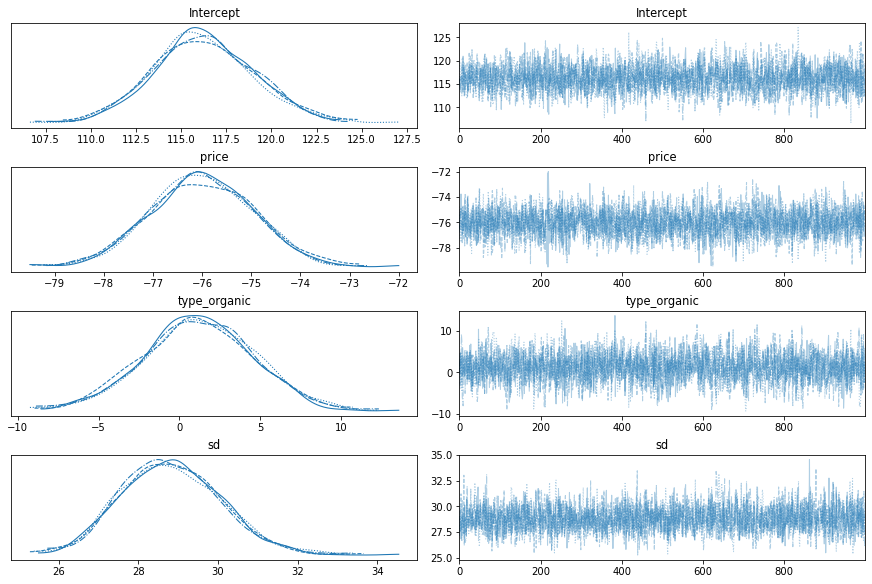

C:\Users\DmitriGazizulin\anaconda3\envs\intro-to-kaggle-competition\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


                 mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Intercept     116.234  2.769  110.930  121.402      0.056    0.040    2421.0   
price         -76.003  1.042  -77.902  -74.066      0.019    0.014    2869.0   
type_organic    1.195  3.385   -5.328    7.438      0.068    0.052    2460.0   
sd             28.826  1.239   26.558   31.112      0.023    0.016    3000.0   

              ess_tail  r_hat  
Intercept       2151.0    1.0  
price           2875.0    1.0  
type_organic    2330.0    1.0  
sd              2697.0    1.0  


In [7]:
# Draw a trace plot of trace
pm.traceplot(trace)
plt.show()

# Print a summary of trace
summary = pm.summary(trace)
print(summary)

# Get each parameter's posterior mean
intercept_mean = np.mean(trace.get_values('Intercept')) 
organic_mean = np.mean(trace.get_values('type_organic')) 
price_mean = np.mean(trace.get_values('price')) 
sd_mean = np.mean(trace.get_values('sd')) 

Have you noticed something unusual when it comes it MCMC convergence? The r-hat for `price` is one, indicating successful convergence.

#### Optimizing the price

Now, down to business - SCENARIO: _your boss asks you to provide the avocado price that would yield the largest profit, and to state what profit can be expected. Also, they want the price to be divisible by $0.25 so that the customers can easily pay with quarters._

In this exercise, we will use our model to predict the volume and the profit for a couple of sensible prices. Next, we will visualize the predictive distributions to pick the optimal price. Finally, we will compute the credible interval for our profit prediction. Now go and optimize!

C:\Users\DmitriGazizulin\AppData\Local\Temp\ipykernel_8628\1569713258.py:10: DeprecationWarning: The function `forestplot` from PyMC3 is just an alias for `plot_forest` from ArviZ. Please switch to `pymc3.plot_forest` or `arviz.plot_forest`.
  pm.forestplot(predicted_profit_per_price)


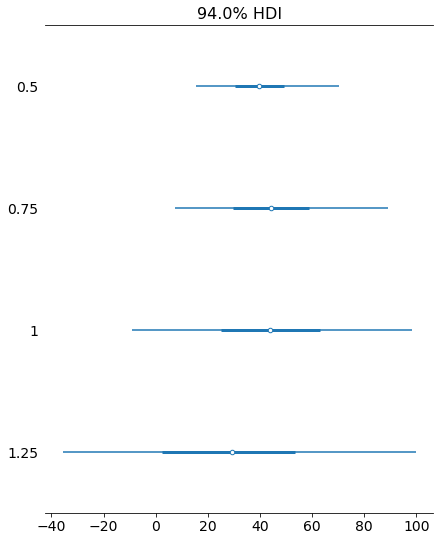

In [9]:
# For each price, predict volume and use it to predict profit
predicted_profit_per_price = {}
for price in [0.5, 0.75, 1, 1.25]:
    pred_mean = (intercept_mean + price_mean * price + organic_mean)
    volume_pred = np.random.normal(pred_mean, sd_mean, size=1000)
    profit_pred = price * volume_pred
    predicted_profit_per_price.update({price: profit_pred})
    
# Draw a forest plot of predicted profit for all prices
pm.forestplot(predicted_profit_per_price)
plt.show()

In [10]:
# Calculate and print HPD of predicted profit for the optimal price
# opt_hpd = pm.hpd(predicted_profit_per_price[0.75])
opt_hpd = az.hdi(predicted_profit_per_price[0.75], hdi_prob=0.99)
print(opt_hpd)

[-12.28268496 105.67868512]


Terrfic work! With a higher or lower price, your comapny would lose profit, but thanks to your modeling skills, they were able to set the best possible price. More than that, knowing the uncertainty in the profit prediction, they can prepare for the worst-case scenario (in which the profit is negative)!